## Image registration

https://en.wikipedia.org/wiki/Image_registration

1. Intensity-based vs feature based
    1. Intensity-based: compare intensity patterns in images via correlation metrics
    2. feature-based: find correspondence between image features such as points, lines, and contours
2. **Transformation models**
    1. Linear -- Affine transform
    2. Elastic or nonrigid -- locally wrapping methods
    3. Diffeomorphic mapping -- LDDMM (Large deformation diffeomorphic metric mapping, https://en.wikipedia.org/wiki/Large_deformation_diffeomorphic_metric_mapping)
3. Spatial and frequency domain methods (phase correlation)
4. Single- vs multi-modality (imaging from different sources)

### Optimization -- Similarity measures for image registration

1. Mean square difference (intensity difference)
2. Mutual information (or nomalized mutual information) -- most popular one
3. Cross-correlation -- more computationally intensive than MI, can be useful for fine-scale nonlinear registration step
4. Ratio image uniformity (this could be useful while images from different imaging modality)
5. Landmark guidance

## Intra-modal registration

### Linear transform
Y = T X + b
### Rigid body transform
Rotation and translation.
### Affine transform
Rotation, translation, scaling and shears.


Ants code
```bash
antsRegistration --dimensionality 3 --float 0 \  
        --output [$thisfolder/pennTemplate_to_${sub}_,$thisfolder/pennTemplate_to_${sub}_Warped.nii.gz] \  
        --interpolation Linear \  
        --winsorize-image-intensities [0.005,0.995] \  # remove hot spots -- preprocessing
        --use-histogram-matching 0 \  # ajust the images with the same constrast -- preprocessing
        --initial-moving-transform [$t1brain,$template,1] \   
        --transform Affine[0.1] \  # 0.1 gradient descent step -- this is done using L-BFGS-B in dipy
        --metric MI[$t1brain,$template,1,32,Regular,0.25] \  # parameters are [fixed, moving, weight, bins, sampling, samplingPercentage]
        --convergence [1000x500x250x100,1e-6,10] \  # run 4 levels (or multi-resolution steps) with a maximum number of iterations of 1000,500,250,100. The threshold (1e-6) tells the algorithm to stop if the improvement in mutual information has not changed more than 1e-6 in the last 10 iterations  -- this is done using L-BFGS-B in dipy
        --shrink-factors 8x4x2x1 \  # the 4 hierarchical steps will have resolutions divided by 8,4,2,1
        --smoothing-sigmas 3x2x1x0vox #  smoothing values for each step: sigma 3,2,1,0
```

In [30]:
from dipy.align.transforms import TranslationTransform2D, TranslationTransform3D, RigidTransform2D, RigidTransform3D, AffineTransform2D, AffineTransform3D
from dipy.align.imaffine import MutualInformationMetric, AffineRegistration

def estimate_affine(fixed, moving, trans_key = 'rigid'):
    assert len(moving.shape) == len(fixed.shape)
    if len(moving.shape) == 2:
        translation = TranslationTransform2D()
        rigid = RigidTransform2D()
        affine = AffineTransform2D()
    elif len(moving.shape) == 3:
        translation = TranslationTransform3D()
        rigid = RigidTransform3D()
        affine = AffineTransform3D()
    
    nbins = 32
    sampling_prop = .25
    metric = MutualInformationMetric(nbins, sampling_prop) #MI
    level_iters = [1000, 500, 250, 125]
    factors = [8, 4, 2, 1]
    sigmas = [3.0, 2.0, 1.0, 0.0]
    # method could be CG, BFGS, Newton-CG, dogleg or trust-ncg

    params0 = None
    
    affmap = AffineRegistration(metric=metric, level_iters=level_iters, sigmas=sigmas, 
                                factors=factors, method='L-BFGS-B', ss_sigma_factor=None, 
                                options=None, verbosity=0)
    tx_tr = affmap.optimize(fixed, moving, translation, params0)
    if trans_key == 'translation':
        tx = tx_tr
    elif trans_key == 'rigid':
        tx = affmap.optimize(fixed, moving, rigid, params0, starting_affine = tx_tr.affine)
    elif trans_key == 'affine':
        tx = affmap.optimize(fixed, moving, rigid, params0, starting_affine = tx_tr.affine)
        tx = affmap.optimize(fixed, moving, affine, params0, starting_affine = tx.affine)
    
    return tx

In [12]:
from skimage.io import imread

move = imread('move.tif', as_grey=True)
fix = imread('fix.tif', as_grey=True)

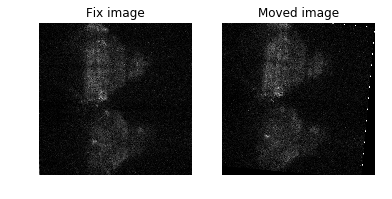

In [14]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(fix, cmap='gray')
ax1.set_title('Fix image')
ax1.axis('off')
ax2.imshow(move, cmap='gray')
ax2.set_title('Moved image')
ax2.axis('off')
plt.show()

In [32]:
%%time
out_affine = estimate_affine(fix, move, trans_key ='rigid')

CPU times: user 1min 33s, sys: 9.95 s, total: 1min 43s
Wall time: 1min 4s


In [38]:
import dipy.io as dipyio
dipyio.save_pickle('affine', out_affine)
out_ = dipyio.load_pickle('affine')

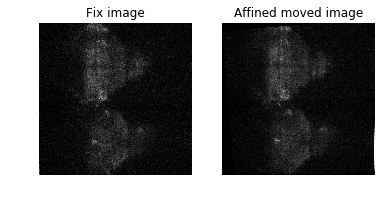

In [40]:
warped_ = out_.transform(move)
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(fix, cmap='gray')
ax1.set_title('Fix image')
ax1.axis('off')
ax2.imshow(warped_, cmap='gray')
ax2.set_title('Affined moved image')
ax2.axis('off')
plt.show()

## Inter-modal registration

### Nonliear transform -- Large deformation diffeomorphic metric mapping (LDDMM)

Image I is a diffeomorphism of template image $I_{tmp}$ as $\psi: I_{tmp} \rightarrow I$ and $\psi \in Diff_v$, and $I = I_{tmp} \circ \psi$ ($\circ$ elementwise multiplication).

The diffeomorphisms are generated via smooth flows $\phi_t$ ($t\in[0,1]$), $\psi = \phi_1$ satisfying the  Lagrangian and Eulerian specification of the flow field associated to the ordinary differential equation, $\frac{d}{dt}\phi_t = v_t \circ \phi_t$ and $\phi_0 = id$

![](ant-syn.png)

1. First term (in blue): smoothness term (or diffeomorphic regularization) -- Minimize a smooth velocity field: the geodesic path between two images. L is a smoothing operator, v is a transform (velocity field), t is time.
2. Second term (rest): similarity metrics

## live registration
```bash
antsRegistration -d 3 –float 1 -o [fish1 , fish1 Warped.nii.gz] \
                 –interpolation WelchWindowedSinc \
                 –use-histogram-matching 0 \
                 -r [ref/vglut-ref.nii, fish1–01.nii.gz,1] \
                 -t rigid[0.1]\
                 -m MI[ref/vglut-ref.nii, fish1–01.nii.gz,1,32, Regular,0.25]\
                 -c [200x200x200x0,1e-8,10]\ 
                 –shrink-factors 12x8x4x2\
                 –smoothing-sigmas 4x3x2x1vox\
                 -t Affine[0.1]
                 -m MI[ref/vglut-ref.nii, fish1–01.nii.gz,1,32, Regular,0.25]
                 -c [200x200x200x0,1e-8,10]
                 –shrink-factors 12x8x4x2
                 –smoothing-sigmas 4x3x2x1vox
                 -t SyN[0.05,6,0.5]
                 -m CC[ref/vglut-ref.nii, fish1–01.nii.gz,1,2]
                 -c [200x200x200x200x10,1e-7,10]
                 –shrink-factors 12x8x4x2x1
                 –smoothing-sigmas 4x3x2x1x0vox

```

float : 0 (double), 1 (float)
interpolation: Several interpolation options are available in ITK. These have all been made available. Currently the interpolator choice is only used to warp (and possibly inverse warp) the final output image(s).

## fixed registration
for Syn using parameters[0.1,6,0]
